Epoch 0: D Loss: 1.4052, G Loss: 0.5775
Epoch 20: D Loss: 1.3696, G Loss: 0.5998
Epoch 40: D Loss: 1.3499, G Loss: 0.6141
Epoch 60: D Loss: 1.2857, G Loss: 0.6689
Epoch 80: D Loss: 1.1858, G Loss: 0.7537
Epoch 100: D Loss: 1.1398, G Loss: 0.7679
Epoch 120: D Loss: 1.1418, G Loss: 0.7457
Epoch 140: D Loss: 1.1369, G Loss: 0.7281
Epoch 160: D Loss: 1.0904, G Loss: 0.7621
Epoch 180: D Loss: 1.0372, G Loss: 0.8247
Epoch 200: D Loss: 0.9261, G Loss: 0.9477
Epoch 220: D Loss: 0.7914, G Loss: 1.1255
Epoch 240: D Loss: 0.7676, G Loss: 1.2388
Epoch 260: D Loss: 0.9876, G Loss: 1.0533
Epoch 280: D Loss: 1.4465, G Loss: 0.7040
Epoch 300: D Loss: 1.2485, G Loss: 0.9889
Epoch 320: D Loss: 1.1259, G Loss: 1.3667
Epoch 340: D Loss: 1.2140, G Loss: 1.2591
Epoch 360: D Loss: 1.5564, G Loss: 1.0656
Epoch 380: D Loss: 1.6723, G Loss: 0.9137
Epoch 400: D Loss: 1.4832, G Loss: 1.0177
Epoch 420: D Loss: 1.3535, G Loss: 1.0262
Epoch 440: D Loss: 1.2845, G Loss: 0.9896
Epoch 460: D Loss: 1.2606, G Loss: 0.920

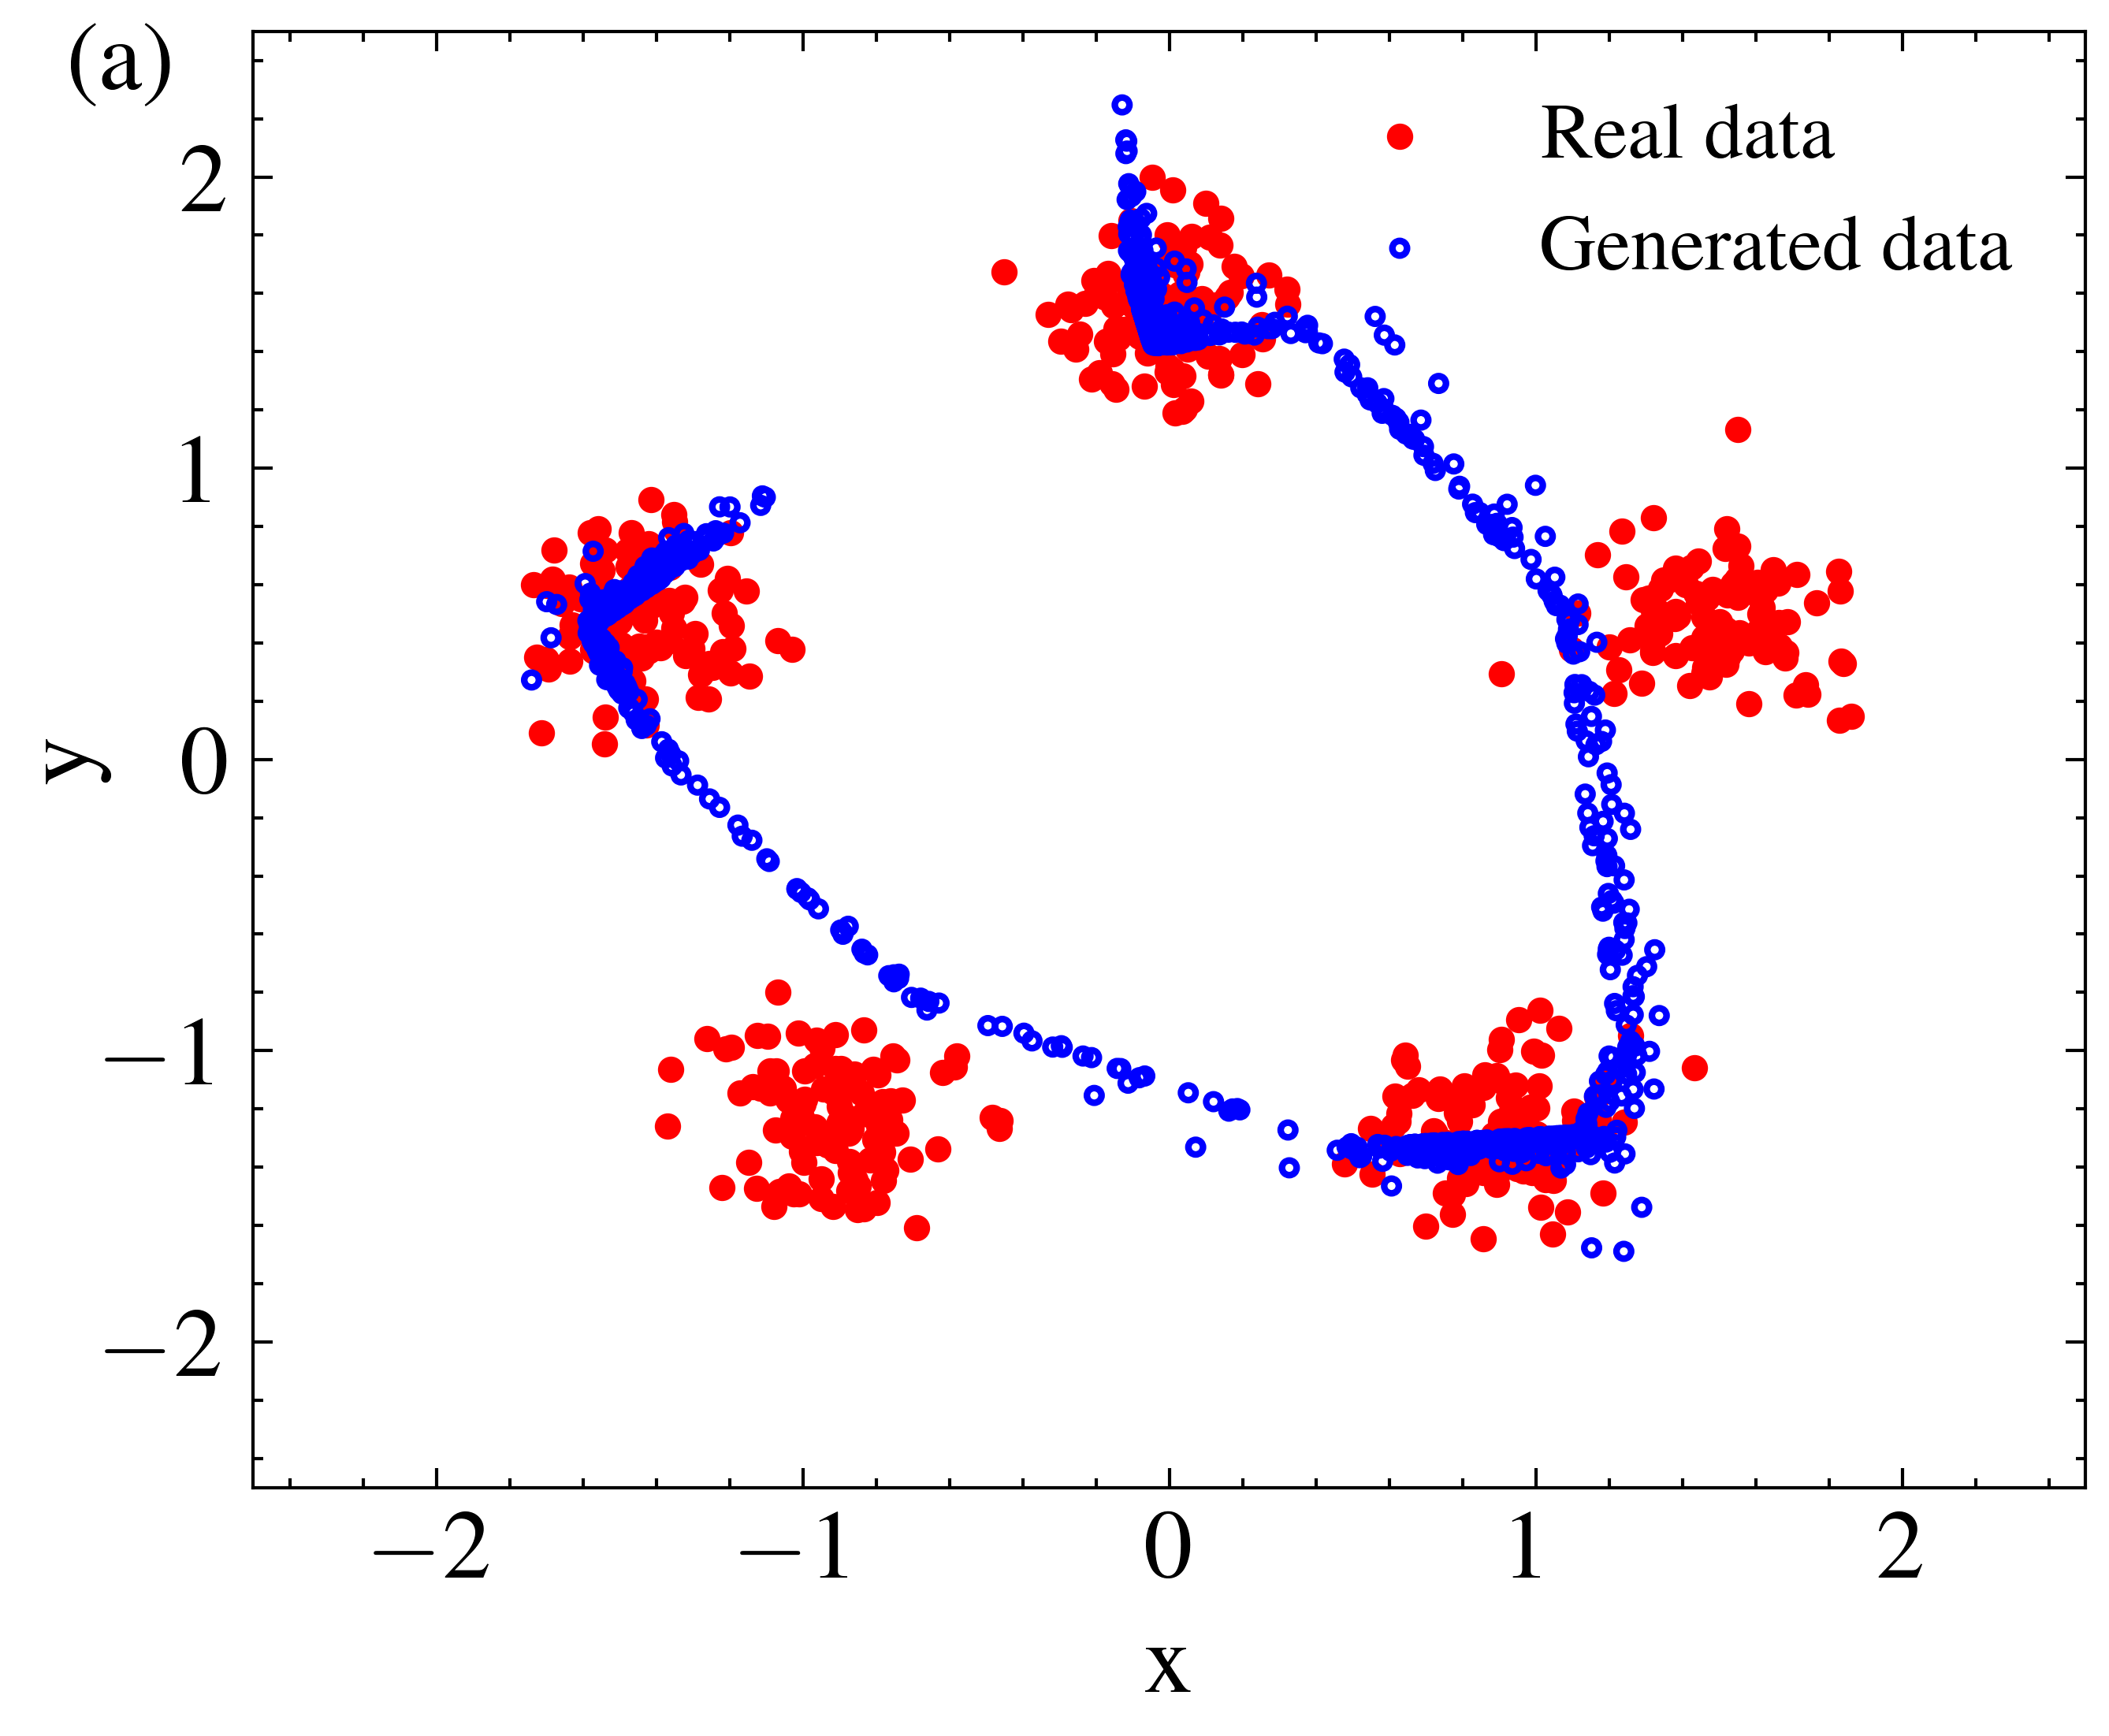

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

# 设置随机数种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

def genGauss(p, n=1, r=1):
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal([math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], [[0.0125, 0], [0, 0.0125]], p).T
        x.append(x_t)
        y.append(y_t)

    x = np.array(x).flatten()[:, None]
    y = np.array(y).flatten()[:, None]
    x -= np.mean(x)
    y -= np.mean(y)
    train = np.concatenate((x, y), axis=1)

    return train / (np.max(train) * r)

class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, x_dim)

        self.relu = nn.ReLU()

    def forward(self, z_input):
        g_y1 = self.relu(self.fc1(z_input))
        g_y2 = self.relu(self.fc2(g_y1))
        g_y3 = self.relu(self.fc3(g_y2))
        g_y4 = self.fc4(g_y3)
        return g_y4

class Discriminator(nn.Module):
    def __init__(self, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_input):
        d_y1 = self.relu(self.fc1(x_input))
        d_y2 = self.relu(self.fc2(d_y1))
        d_y3 = self.relu(self.fc3(d_y2))
        d_y4 = self.fc4(d_y3)
        output = self.sigmoid(d_y4)
        return output, d_y4

# 自定义损失函数
def discriminator_loss(d_real, d_fake):
    # 判别器希望 d_real 接近 1，d_fake 接近 0
    d_loss_real = -torch.mean(torch.log(d_real + 1e-8))  # 添加一个小常数避免 log(0)
    d_loss_fake = -torch.mean(torch.log(1 - d_fake + 1e-8))
    return d_loss_real + d_loss_fake

def generator_loss(d_fake):
    # 生成器希望 d_fake 接近 1
    return -torch.mean(torch.log(d_fake + 1e-8))

# Hyperparameters
nb_neurons_h1 = 16
nb_neurons_h2 = 16
nb_neurons_h3 = 16
learning_rate = 5e-5
batch_size = 32

z_dim = 2
x_dim = 2
img_dim = 2

# Initialize models
generator = Generator(z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3)
discriminator = Discriminator(x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

epochs = 5000
X_train = genGauss(100, 5, 0.5)
X_train = torch.Tensor(X_train)
indices = torch.randperm(X_train.size(0))  # 获取打乱后的索引
X_train = X_train[indices]  # 根据新的索引重新排序 X_train

epoch_discriminator_loss = []
epoch_generator_loss = []

# Training loop
for epoch in range(epochs):
    batch_discriminator_loss = []
    batch_generator_loss = []
    nb_batches = int(X_train.shape[0] / batch_size)

    for i in range(nb_batches):
        image_batch = X_train[i * batch_size:(i + 1) * batch_size]

        # Train discriminator
        z_input = torch.randn(batch_size, z_dim)
        fake_img = generator(z_input)

        # Discriminator loss on real images
        d_real, _ = discriminator(image_batch)
        d_fake, _ = discriminator(fake_img.detach())

        # 使用自定义的判别器损失函数
        d_loss = discriminator_loss(d_real, d_fake)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        d_fake, _ = discriminator(fake_img)

        # 使用自定义的生成器损失函数
        g_loss = generator_loss(d_fake)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Track losses
        batch_discriminator_loss.append(d_loss.item())
        batch_generator_loss.append(g_loss.item())

    epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
    epoch_generator_loss.append(np.mean(batch_generator_loss))

    # Print losses every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: D Loss: {np.mean(batch_discriminator_loss):.4f}, G Loss: {np.mean(batch_generator_loss):.4f}")
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science','ieee'])
# 生成 GAN 的输出数据（假设 samples 是 GAN 生成的样本）
samples = generator(torch.randn(1000, z_dim)).detach().numpy()

# 图 (a): 真实数据 vs 生成数据
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad=-1)
ax.set_xlim(-2.5, 2.5)  # 设置 x 轴范围
ax.set_ylim(-2.5, 2.5)  # 设置 y 轴范围

# 绘制真实数据（红色星号）
ax.scatter(X_train[:, 0], X_train[:, 1], color="red", label='Real data', marker='.')
# 绘制生成数据（蓝色点）
ax.scatter(samples[:, 0], samples[:, 1], color="blue", label='Generated data', marker='o', facecolors='none', edgecolors='blue',s=5)
ax.legend(loc='upper right', fontsize=12)
ax.text(-3, 2.3, '(a)', fontsize=15)  # 标记 (a)
fig.savefig('D:/GAN2024/Fig2a.eps', dpi=800)
# 显示图 (a)
plt.show()

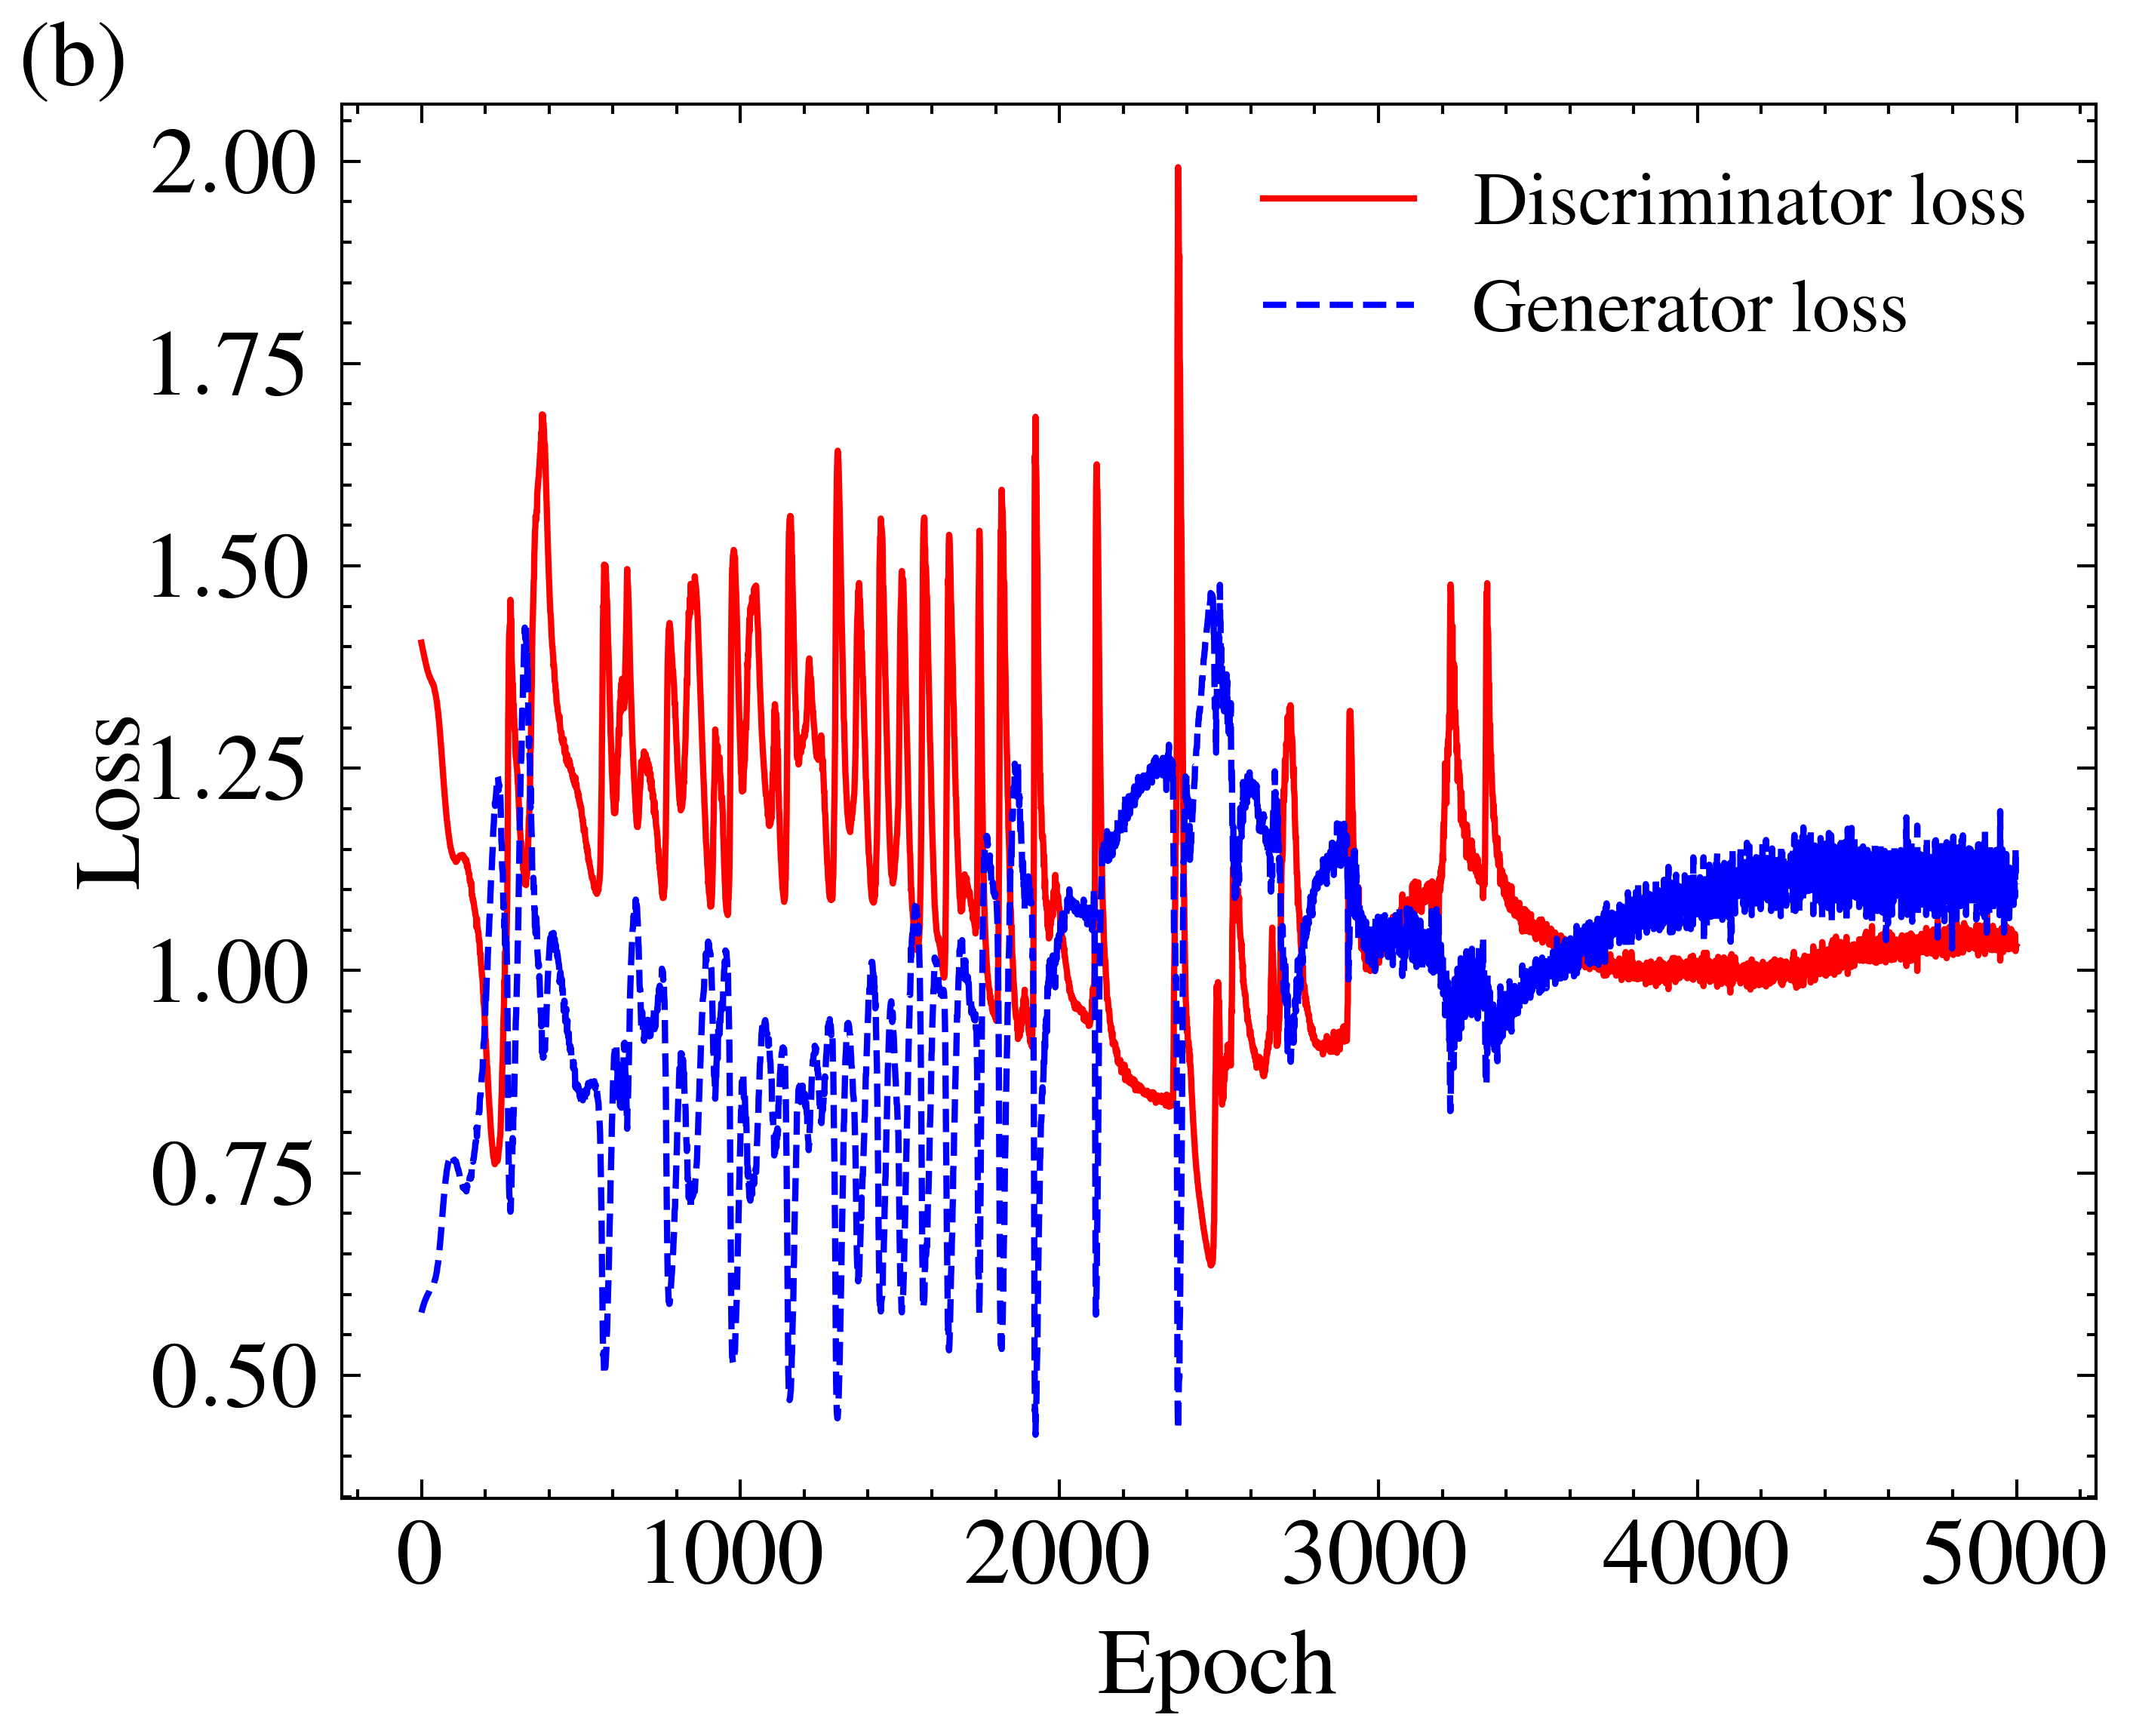

In [43]:
# 图 (b): 损失曲线
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15, labelpad=-1)

# 绘制判别器损失曲线
ax.plot(epoch_discriminator_loss, color='red', label='Discriminator loss')
# 绘制生成器损失曲线
ax.plot(epoch_generator_loss, color='blue', label='Generator loss')
ax.legend(loc='upper right', fontsize=12)
ax.text(-1250, max(epoch_discriminator_loss) + 0.1, '(b)', fontsize=15)  # 标记 (b)
fig.savefig('D:/GAN2024/Fig2b.eps', dpi=800)
# 显示图 (b)
plt.show()

Epoch 0: D Loss: 1.4056, G Loss: 0.5782
Epoch 20: D Loss: 1.3816, G Loss: 0.6011
Epoch 40: D Loss: 1.3586, G Loss: 0.6224
Epoch 60: D Loss: 1.3285, G Loss: 0.6406
Epoch 80: D Loss: 1.3021, G Loss: 0.6619
Epoch 100: D Loss: 1.2548, G Loss: 0.6916
Epoch 120: D Loss: 1.1991, G Loss: 0.7361
Epoch 140: D Loss: 1.1206, G Loss: 0.8070
Epoch 160: D Loss: 1.0398, G Loss: 0.9028
Epoch 180: D Loss: 0.9481, G Loss: 0.9910
Epoch 200: D Loss: 0.8784, G Loss: 1.0456
Epoch 220: D Loss: 0.8026, G Loss: 1.1022
Epoch 240: D Loss: 0.7249, G Loss: 1.1526
Epoch 260: D Loss: 0.6597, G Loss: 1.2259
Epoch 280: D Loss: 0.6193, G Loss: 1.2836
Epoch 300: D Loss: 0.5721, G Loss: 1.3792
Epoch 320: D Loss: 0.5776, G Loss: 1.3682
Epoch 340: D Loss: 0.6344, G Loss: 1.3774
Epoch 360: D Loss: 0.7052, G Loss: 1.4071
Epoch 380: D Loss: 0.7749, G Loss: 1.4937
Epoch 400: D Loss: 0.7760, G Loss: 1.6798
Epoch 420: D Loss: 0.7712, G Loss: 1.7985
Epoch 440: D Loss: 0.7558, G Loss: 1.8980
Epoch 460: D Loss: 0.7926, G Loss: 1.776

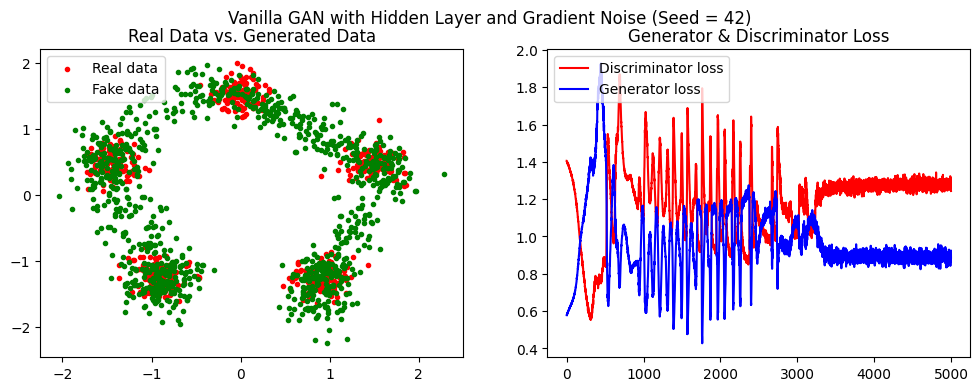

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

# 设置随机数种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

def genGauss(p, n=1, r=1):
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal([math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], [[0.0125, 0], [0, 0.0125]], p).T
        x.append(x_t)
        y.append(y_t)

    x = np.array(x).flatten()[:, None]
    y = np.array(y).flatten()[:, None]
    x -= np.mean(x)
    y -= np.mean(y)
    train = np.concatenate((x, y), axis=1)

    return train / (np.max(train) * r)

class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0.1):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, x_dim)

        self.relu = nn.ReLU()
        self.noise_std = noise_std

    def forward(self, z_input):
        # 添加噪声到输入
        z_input = z_input + torch.randn_like(z_input) * self.noise_std
        g_y1 = self.relu(self.fc1(z_input))
        g_y1 = g_y1 + torch.randn_like(g_y1) * self.noise_std  # 添加噪声到隐藏层
        g_y2 = self.relu(self.fc2(g_y1))
        g_y2 = g_y2 + torch.randn_like(g_y2) * self.noise_std  # 添加噪声到隐藏层
        g_y3 = self.relu(self.fc3(g_y2))
        g_y3 = g_y3 + torch.randn_like(g_y3) * self.noise_std  # 添加噪声到隐藏层
        g_y4 = self.fc4(g_y3)
        return g_y4

class Discriminator(nn.Module):
    def __init__(self, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0.1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.noise_std = noise_std

    def forward(self, x_input):
        # 添加噪声到输入
        x_input = x_input + torch.randn_like(x_input) * self.noise_std
        d_y1 = self.relu(self.fc1(x_input))
        d_y1 = d_y1 + torch.randn_like(d_y1) * self.noise_std  # 添加噪声到隐藏层
        d_y2 = self.relu(self.fc2(d_y1))
        d_y2 = d_y2 + torch.randn_like(d_y2) * self.noise_std  # 添加噪声到隐藏层
        d_y3 = self.relu(self.fc3(d_y2))
        d_y3 = d_y3 + torch.randn_like(d_y3) * self.noise_std  # 添加噪声到隐藏层
        d_y4 = self.fc4(d_y3)
        output = self.sigmoid(d_y4)
        return output, d_y4

# 自定义损失函数
def discriminator_loss(d_real, d_fake):
    # 判别器希望 d_real 接近 1，d_fake 接近 0
    d_loss_real = -torch.mean(torch.log(d_real + 1e-8))  # 添加一个小常数避免 log(0)
    d_loss_fake = -torch.mean(torch.log(1 - d_fake + 1e-8))
    return d_loss_real + d_loss_fake

def generator_loss(d_fake):
    # 生成器希望 d_fake 接近 1
    return -torch.mean(torch.log(d_fake + 1e-8))

# 梯度噪声注入函数
def add_gradient_noise(parameters, grad_noise_std):
    for param in parameters:
        if param.grad is not None:
            noise = torch.randn_like(param.grad) * grad_noise_std
            param.grad += noise

# Hyperparameters
nb_neurons_h1 = 16
nb_neurons_h2 = 16
nb_neurons_h3 = 16
learning_rate = 5e-5
batch_size = 32
noise_std = 0.1  # 隐藏层噪声标准差
grad_noise_std = 0.01  # 梯度噪声标准差

z_dim = 2
x_dim = 2
img_dim = 2

# Initialize models
generator = Generator(z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)
discriminator = Discriminator(x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

epochs = 5000
X_train = genGauss(100, 5, 0.5)
X_train = torch.Tensor(X_train)
indices = torch.randperm(X_train.size(0))  # 获取打乱后的索引
X_train = X_train[indices]  # 根据新的索引重新排序 X_train

epoch_discriminator_loss = []
epoch_generator_loss = []

# Training loop
for epoch in range(epochs):
    batch_discriminator_loss = []
    batch_generator_loss = []
    nb_batches = int(X_train.shape[0] / batch_size)

    for i in range(nb_batches):
        image_batch = X_train[i * batch_size:(i + 1) * batch_size]

        # Train discriminator
        z_input = torch.randn(batch_size, z_dim)
        fake_img = generator(z_input)

        # Discriminator loss on real images
        d_real, _ = discriminator(image_batch)
        d_fake, _ = discriminator(fake_img.detach())

        # 使用自定义的判别器损失函数
        d_loss = discriminator_loss(d_real, d_fake)

        d_optimizer.zero_grad()
        d_loss.backward()
        add_gradient_noise(discriminator.parameters(), grad_noise_std)  # 梯度噪声注入
        d_optimizer.step()

        # Train generator
        d_fake, _ = discriminator(fake_img)

        # 使用自定义的生成器损失函数
        g_loss = generator_loss(d_fake)

        g_optimizer.zero_grad()
        g_loss.backward()
        add_gradient_noise(generator.parameters(), grad_noise_std)  # 梯度噪声注入
        g_optimizer.step()

        # Track losses
        batch_discriminator_loss.append(d_loss.item())
        batch_generator_loss.append(g_loss.item())

    epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
    epoch_generator_loss.append(np.mean(batch_generator_loss))

    # Print losses every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: D Loss: {np.mean(batch_discriminator_loss):.4f}, G Loss: {np.mean(batch_generator_loss):.4f}")

# 训练完成后，生成最后的样本
samples = generator(torch.randn(1000, z_dim)).detach().numpy()

# 绘图部分
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

# 绘制真实数据与生成数据对比（使用最后生成的样本）
axarr[0].set_title('Real Data vs. Generated Data')
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c='red', label='Real data', marker='.')
axarr[0].scatter(samples[:, 0], samples[:, 1], c='green', label='Fake data', marker='.')
axarr[0].legend(loc='upper left')

# 绘制生成器和判别器的损失曲线
axarr[1].set_title('Generator & Discriminator Loss')
axarr[1].plot(epoch_discriminator_loss, color='red', label='Discriminator loss')
axarr[1].plot(epoch_generator_loss, color='blue', label='Generator loss')
axarr[1].legend(loc='upper left')

fig.suptitle(f'Vanilla GAN with Hidden Layer and Gradient Noise (Seed = {seed})')
plt.show()

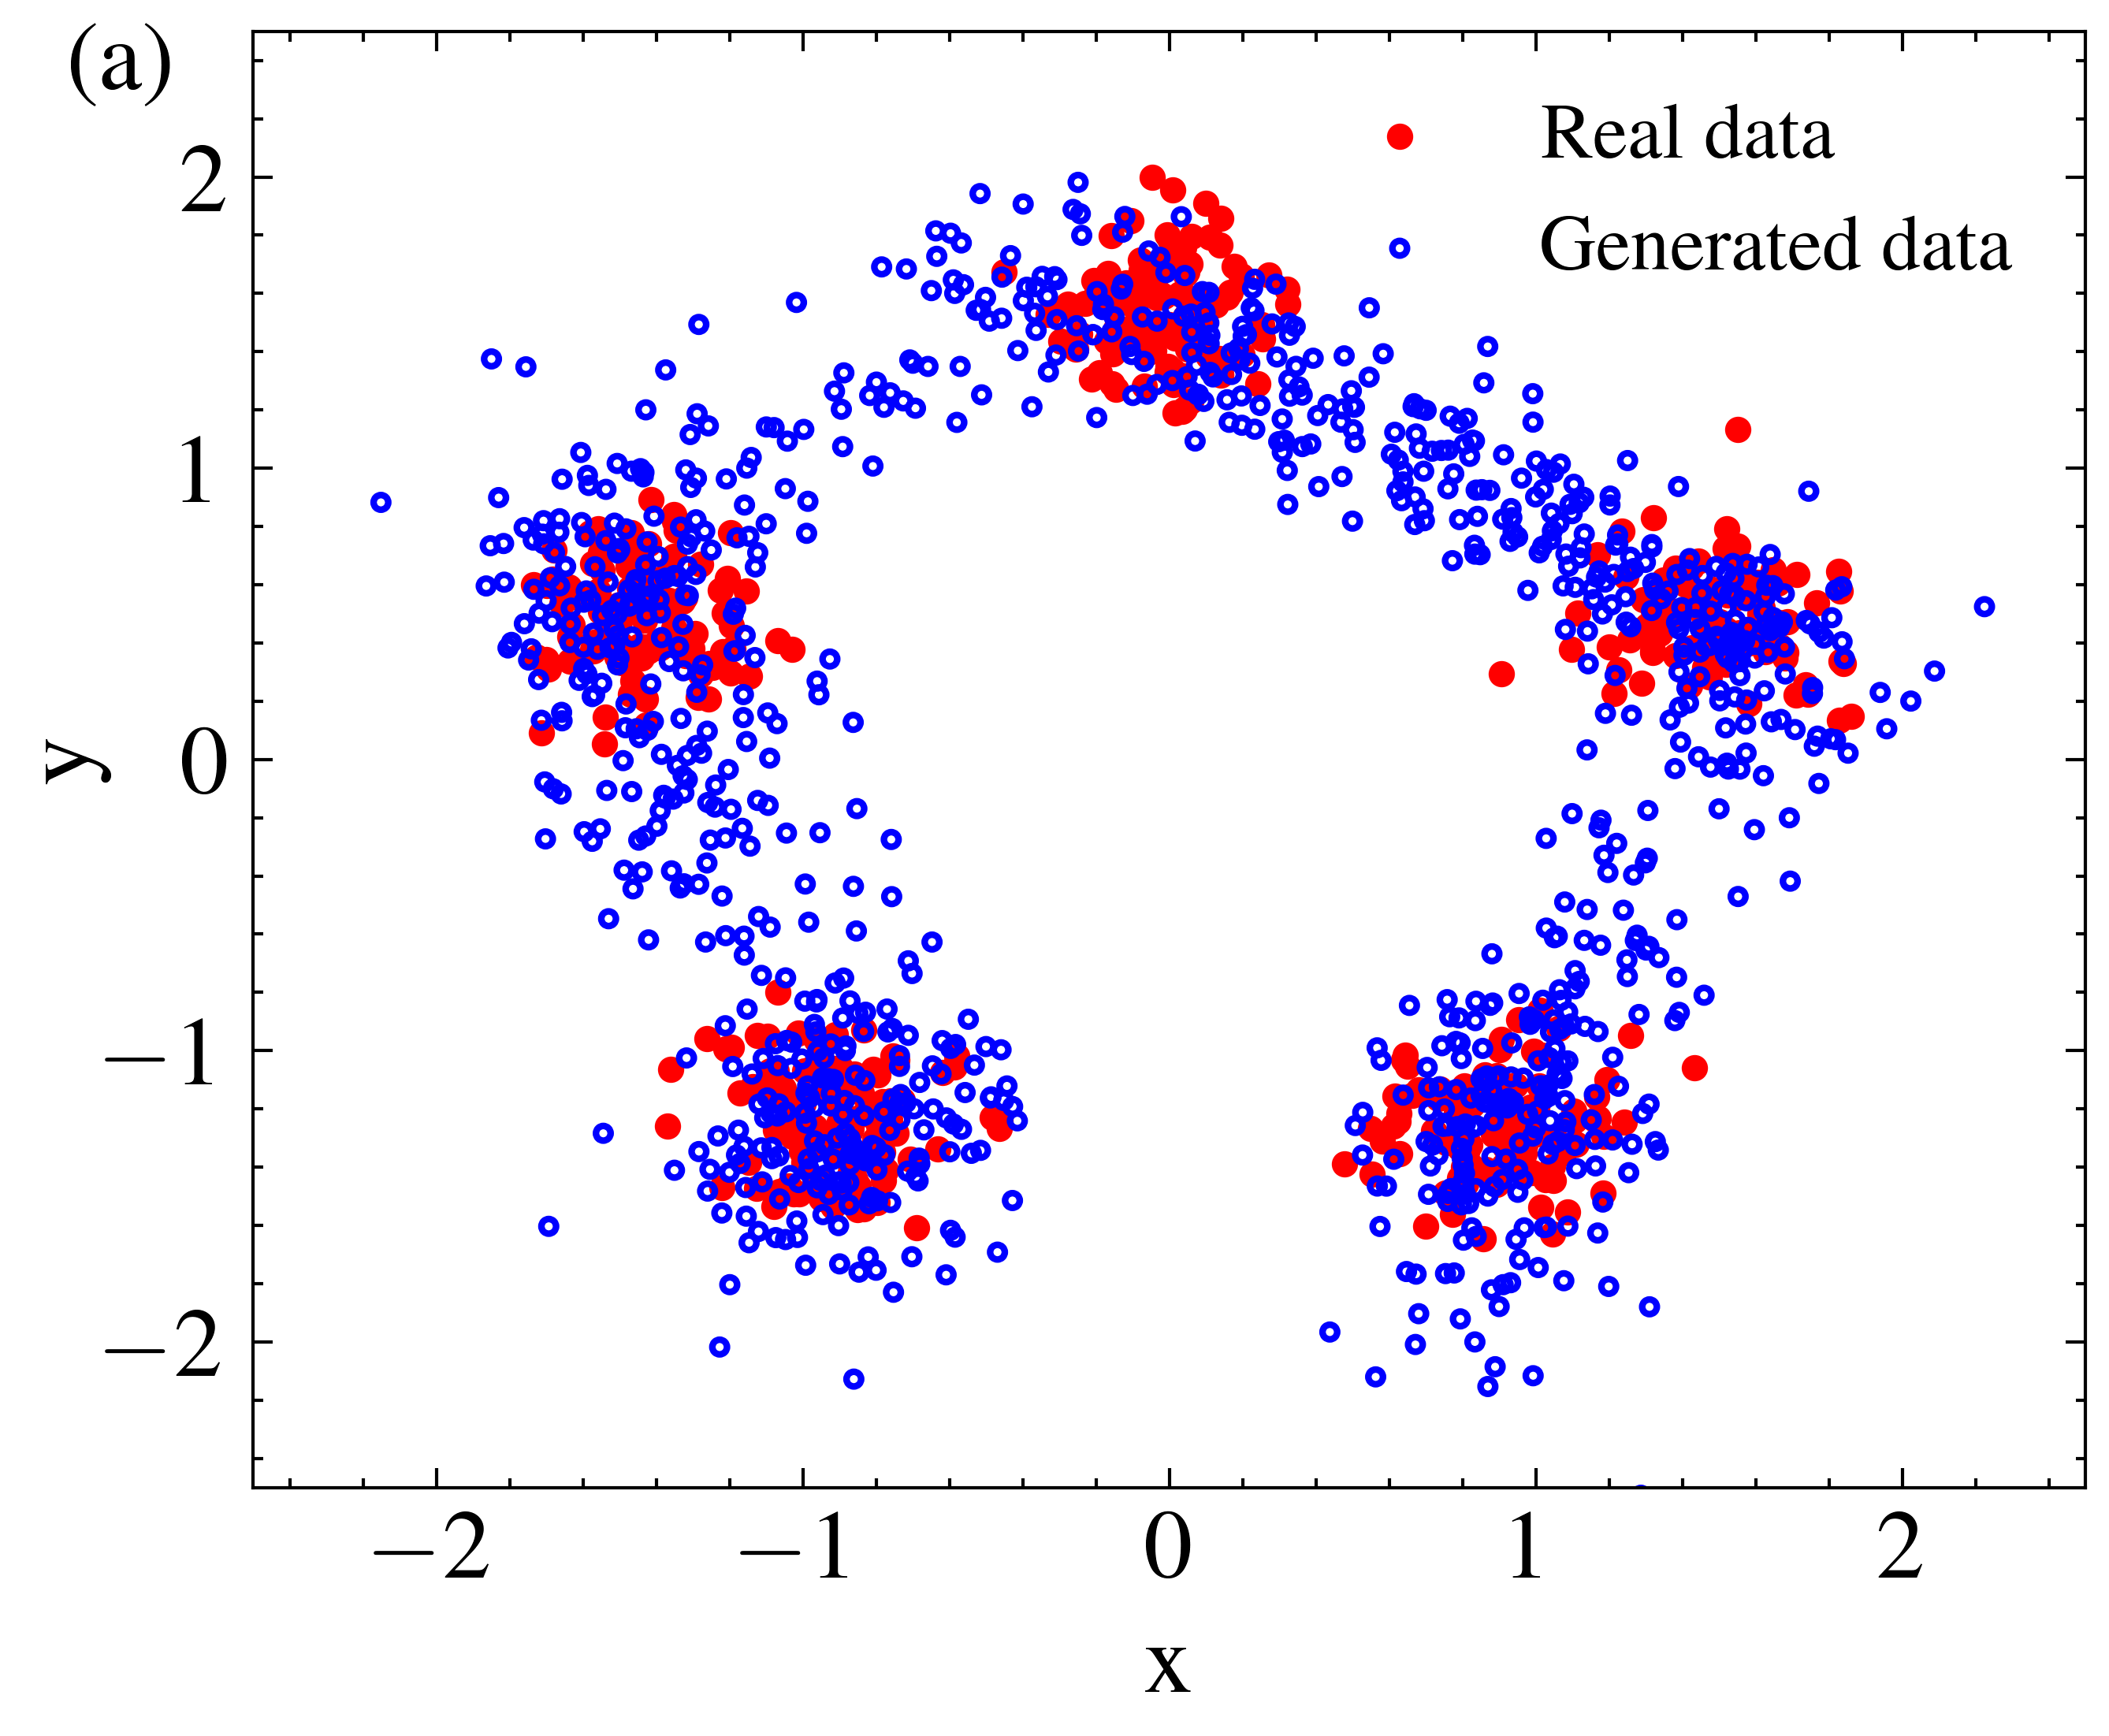

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import numpy as np

# 设置全局样式
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science','ieee'])
# 生成 GAN 的输出数据（假设 samples 是 GAN 生成的样本）
samples = generator(torch.randn(1000, z_dim)).detach().numpy()

# 图 (a): 真实数据 vs 生成数据
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad=-1)
ax.set_xlim(-2.5, 2.5)  # 设置 x 轴范围
ax.set_ylim(-2.5, 2.5)  # 设置 y 轴范围

# 绘制真实数据（红色星号）
ax.scatter(X_train[:, 0], X_train[:, 1], color="red", label='Real data', marker='.')
# 绘制生成数据（蓝色点）
ax.scatter(samples[:, 0], samples[:, 1], color="blue", label='Generated data', marker='o', facecolors='none', edgecolors='blue',s=5)
ax.legend(loc='upper right', fontsize=12)
ax.text(-3, 2.3, '(a)', fontsize=15)  # 标记 (a)
fig.savefig('D:/GAN2024/Fig1a.eps', dpi=800)
# 显示图 (a)
plt.show()

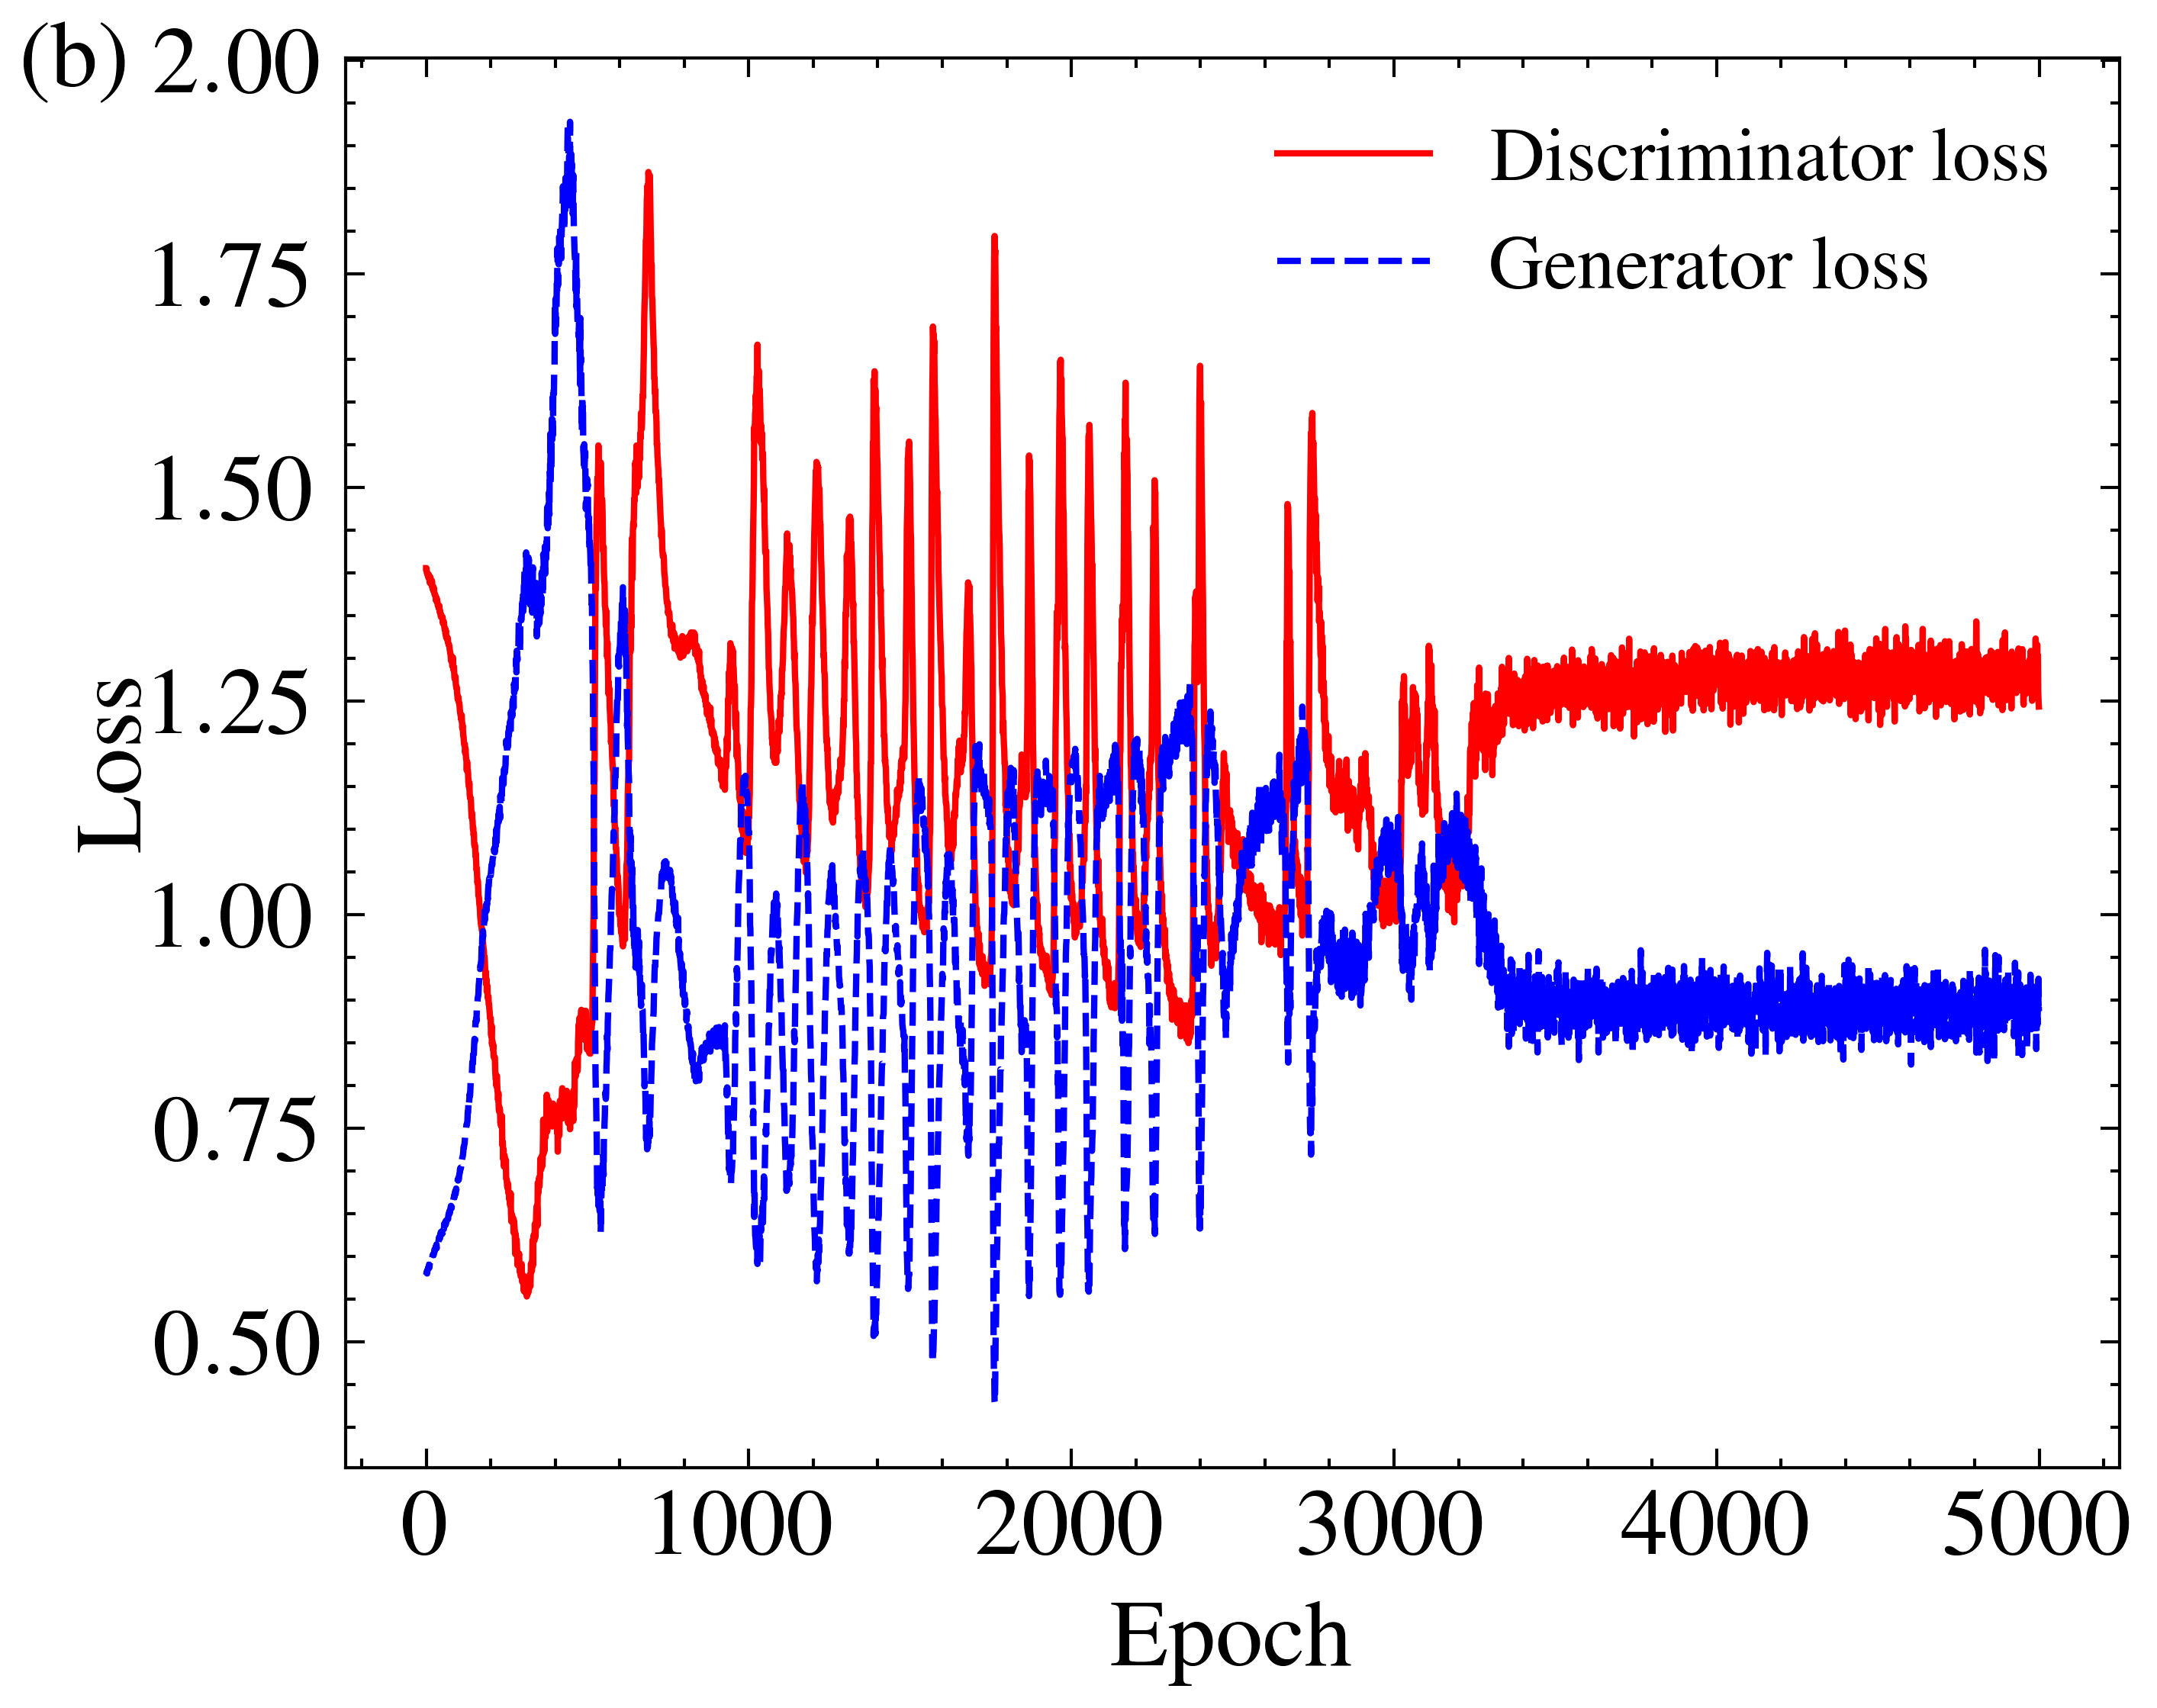

In [35]:
# 图 (b): 损失曲线
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15, labelpad=-1)

# 绘制判别器损失曲线
ax.plot(epoch_discriminator_loss, color='red', label='Discriminator loss')
# 绘制生成器损失曲线
ax.plot(epoch_generator_loss, color='blue', label='Generator loss')
ax.legend(loc='upper right', fontsize=12)
ax.text(-1250, max(epoch_discriminator_loss) + 0.1, '(b)', fontsize=15)  # 标记 (b)
fig.savefig('D:/GAN2024/Fig1b.eps', dpi=800)
# 显示图 (b)
plt.show()